## Notebook for CNN training for AE4317 Autonomous Flight of Micro Air Vehicles
Author: Tim den Blanken (t.n.a.denblanken@student.tudelft.nl)

This notebook assumes you already have a labeled dataset, ready to be used for training. Optionally you can use `Dataset_generation.ipynb` for this, but you could also label them by hand or through any other method. With your own labeled data, you can either tweak the code to match your dataset and labels, or follow the recommended format. This format is as follows: you should have a folder `all_images` containing all your images. Together with this you should have a file `labeled_images.csv` which has the following columns: ['filename', 'your', 'class', 'labels', 'etc'] (any number of classes is possible). The code assumes one-hot encoded labels, if this is not the case, make sure to use the correct loss function for your application.

Training your CNN now becomes rather easy, however it is very important to keep track of how your models are performing such that you can compare them. I recommended to use [Weights and Biases](https://wandb.ai/), you can sign up using your GitHub account. Follow the setup procedure on their website to link your API code. When you have done this, it will log all your data such that you can compare performance between models.

Make sure to go through the entire notebook at least once, and try to understand what every part does and if it is applicable to your method. In the end you will mostly be using the parameter dashboard, as this where you change the model architecture and hyperparameters.

**Keep the following in mind:** 

Originally this notebook was created to train a CNN to classify each image as 'left', 'forward', 'right', which is then connected to a control algorithm on the drone. If you are following the same approach, you won't have to change much in this notebook. If you are taking a different approach, let's say you classify 'left', 'left-forward', 'forward', 'right-forward', 'right', then you will have to adapt this notebook and the control algorithm on the drone accordingly.

Some more interesting points about this notebook:
- This notebook uses [PyTorch Lightning](https://lightning.ai/docs/pytorch/stable/), which is a deep learning framework build on PyTorch, this makes the code more dense and better readable.
- At the end of this notebook your model will be saved in the [.onnx](https://onnx.ai/) file format. This allows for the conversion to C code, more about this at the end.

Let's dive into it!

### Imports
Below are all the imports we need, make sure to have all of them installed.

In [21]:
from utils import calc_mean_std_dataset

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms  
from torchvision.io import read_image
from torchvision.transforms.functional import convert_image_dtype
import torchsummary
import lightning as L
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# check device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cpu


### Parameters Dashboard
This is the main place to tune your CNN. You can fully specify the architecture and a few other hyperparameters, such as the number of epochs and learning rate. All these parameters will also be logged to weights and biases, such that you can see which changes led to better performance. The architecture below is the one used for the competition for AE4317 Autonomous Flight of Micro Air Vehicles of 28-3-24.

In [22]:
# CNN configuration
config = {
    "epochs": 100,
    "learning_rate": 0.01,
    "label_smoothing": 0.0,
    "normalize_images": True,
    "augment_train": True,
    "batch_norm": True,
    "n_layers": 4,                              # when changing the number of layers, make sure change the lengths of the tuples below accordingly
    "conv_layers": {
        "input_size": (1, 40, 12),              # (input_channgels, height, width)
        "output_channel": (8, 16, 32, 64),
        "kernel_size": (3, 3, 3, 3),
        "stride": (1, 1, 1, 1),
        "padding": (1, 1, 1, 1),   
    },
    "max_pool_layers": {
        "kernel_size": ((2,1), 2, 2, 2),
        "stride": ((2,1), 2, 2, 2)
    },
    "dropout_layers": {
        "p": (0.1, 0.05, 0.025, 0.025)
    },
    "fc_layer": {
        "input_size": None,                     # this will be calculated automatically, based on the architecture
        "output_size": None,                    # this will be calculated automatically, based on the number of classes
    }
}

### The dataset and dataloaders
Here we create the dataset using the .csv. Make sure it works with your file structure. Also check the distribution of your labels, and correct for possible uneven distributions.

In [23]:
# Create dataset class
class DroneImagesDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.annotations = pd.read_csv(csv_file, skiprows=1, header=None)
        self.transform = transform

    def __getitem__(self, index):
        img_path = self.annotations.iloc[index, 0]
        img_path = img_path.replace("\\", os.sep)
        image = convert_image_dtype(read_image(img_path), torch.float)
        y_label = torch.tensor(list(self.annotations.iloc[index, 1:]), dtype=torch.float32)
        
        if self.transform:
            image = self.transform(image)

        return (image, y_label)
    
    def __len__(self):
        return len(self.annotations)
    
# First we create a dataset without transform to get the image size and number of classes
dataset = DroneImagesDataset("labeled_images.csv")
image_size = dataset[0][0].shape
config["fc_layer"]["output_size"] = len(dataset[0][1])

images/all/107087828.jpg
images/all/107087828.jpg


Before we pass the images to the CNN we first want to transform them, such as downscaling. For this we define two transforms, one for training, and one for validation and testing. The transform for training also includes training data augmentation, such as changing the brightness, contrast, saturation, hue and rotation. The goal of this is to make your model more robust to changing conditions. Obviously while testing performance we do not want these augmentation, which is why we have defined two transforms. The current transform converts the image to grayscale, crops the top and bottom 25% and resizes it to the size you specified in the `input_size` in the parameter dashboard. Tweak these transforms to your preferences and try to maximize performance. One important point to keep in mind is that any transform you perform on the data here, you will also have to do on the drone itself. For this reason the interpolation mode is set to NEAREST_EXACT, as this seemed to match the downsampling on the drone the best.

Note: the transform used for training data makes the training go rather slow, consider turning off data augmentation while prototyping models and only turn it on once you want to make an already good model more robust.

In [24]:
IMAGE_TRANSFORM = transforms.Compose([
    transforms.Grayscale(),
    transforms.CenterCrop((image_size[1], int(image_size[2]*0.5))),
    transforms.Resize((config["conv_layers"]["input_size"][1], config["conv_layers"]["input_size"][2]), interpolation=transforms.InterpolationMode.NEAREST_EXACT),
])

TRAIN_IMAGE_TRANSFORM = transforms.Compose([
    transforms.ColorJitter(brightness=0.25, contrast=0.15, saturation=0.25, hue=0.03),
    transforms.RandomRotation(degrees=5),
    transforms.Grayscale(),
    transforms.CenterCrop((image_size[1], int(image_size[2]*0.5))),
    transforms.Resize((config["conv_layers"]["input_size"][1], config["conv_layers"]["input_size"][2]), interpolation=transforms.InterpolationMode.NEAREST_EXACT),
])

if config["normalize_images"]:
    # recommendation: calculate the mean and std of the dataset once, and then hardcode it to save computation time
    # mean, std = calc_mean_std_dataset('all_images', IMAGE_TRANSFORM)
    mean, std = 0.3625994920730591, 0.18103595077991486
    print(f"Mean: {mean}, Std: {std}")

    IMAGE_TRANSFORM = transforms.Compose([IMAGE_TRANSFORM,
        transforms.Normalize(mean=[mean], std=[std])
    ])

    TRAIN_IMAGE_TRANSFORM = transforms.Compose([TRAIN_IMAGE_TRANSFORM,
        transforms.Normalize(mean=[mean], std=[std])
    ])

Mean: 0.3625994920730591, Std: 0.18103595077991486


Now we create dataloaders for our training, validation and test set. Feel free to change the sizes for your test and validation set, but don't make them too small!

In [25]:
# Split the dataset into training, validation, and test sets
val_ratio = 0.2
test_ratio = 0.1
batch_size = 128

# Set the appropriate transform for the training set
if config["augment_train"]:
    train_transform = TRAIN_IMAGE_TRANSFORM
else:
    train_transform = IMAGE_TRANSFORM

# Create the datasets
train_dataset_full = DroneImagesDataset(csv_file='labeled_images.csv', transform=train_transform)
val_dataset_full = DroneImagesDataset(csv_file='labeled_images.csv', transform=IMAGE_TRANSFORM)
test_dataset_full = DroneImagesDataset(csv_file='labeled_images.csv', transform=IMAGE_TRANSFORM)

# Split the datasets
indices = torch.randperm(len(train_dataset_full)).tolist()
train_dataset = torch.utils.data.Subset(train_dataset_full, indices[:-int(len(indices)*(val_ratio+test_ratio))])
val_dataset = torch.utils.data.Subset(val_dataset_full, indices[-int(len(indices)*(val_ratio+test_ratio)):-int(len(indices)*test_ratio)])
test_dataset = torch.utils.data.Subset(test_dataset_full, indices[-int(len(indices)*test_ratio):])

# Create DataLoaders for the training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, prefetch_factor=2, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, prefetch_factor=2, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, prefetch_factor=2, persistent_workers=True)

Use the codespace below to plot some of your data and check if the transforms are doing what you expected.

images/all/114287755.jpg
images/all/114287755.jpg


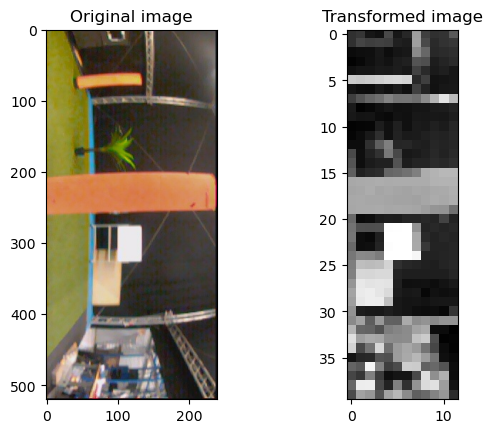

In [29]:
img_original, _ = dataset_no_transform[2]
img_transformed, _ = train_dataset_full[2]

fig, axs = plt.subplots(1, 2)
axs[0].imshow(img_original.permute(1, 2, 0))
axs[0].set_title('Original image')
axs[1].imshow(img_transformed.squeeze(), cmap='gray')
axs[1].set_title('Transformed image')
plt.show()

### Lightning module
Next up is the code that actually creates your model. Make sure to understand the structure and reflect whether the structure makes sense for your data, e.g. if your labels are not one-hot encoded you should use a different loss function. The PyTorch Lightning documentation is a great place to start and understand how all the code works.

Note: currently a learning rate scheduler is implemented, which multiplies the learning rate by 0.5 every 7 epochs. You might want to remove or change this based on your approach, if you are unsure how to change it, the PyTorch Lightning documentation explains how to do this.

In [ ]:
def add_conv_block(config, i):
    if i == 0:
        input_channels = config["conv_layers"]["input_size"][0]
    else:
        input_channels = config["conv_layers"]["output_channel"][i-1]

    return nn.Sequential(
        nn.Conv2d(in_channels=input_channels,
                        out_channels=config["conv_layers"]["output_channel"][i],
                        kernel_size=config["conv_layers"]["kernel_size"][i],
                        stride=config["conv_layers"]["stride"][i],
                        padding=config["conv_layers"]["padding"][i],
                        bias= not config["batch_norm"]),
        nn.BatchNorm2d(config["conv_layers"]["output_channel"][i]) if config["batch_norm"] else nn.Identity(),
        nn.MaxPool2d(kernel_size=config["max_pool_layers"]["kernel_size"][i],
                           stride=config["max_pool_layers"]["stride"][i]),
        nn.ReLU(inplace=True),
        nn.Dropout2d(config["dropout_layers"]["p"][i])
    )

class LightningCNN(L.LightningModule):
    def __init__(self, cfg):
        super().__init__()

        layers = [add_conv_block(config, i) for i in range(config["n_layers"])] + [nn.Flatten()]

        self.embedder = nn.Sequential(*layers)

        with torch.no_grad():
            training = self.embedder.training
            self.embedder.eval()
            cfg["fc_layer"]["input_size"] = self.embedder(torch.empty(1, *cfg["conv_layers"]["input_size"])).size(-1)
            self.embedder.train(training)

        self.fc = nn.Linear(cfg["fc_layer"]["input_size"], cfg["fc_layer"]["output_size"])

        self.save_hyperparameters(cfg)

    def forward(self, x):
        return self.fc(self.embedder(x))

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y, label_smoothing=self.hparams.label_smoothing)
        acc = torch.sum(torch.argmax(y_hat, dim=1) == torch.argmax(y, dim=1)) / len(y)
        self.log("train/loss", loss)
        self.log("train/acc", acc)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = torch.sum(torch.argmax(y_hat, dim=1) == torch.argmax(y, dim=1)) / len(y)
        self.log("val/loss", loss)
        self.log("val/acc", acc)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = torch.sum(torch.argmax(y_hat, dim=1) == torch.argmax(y, dim=1)) / len(y)
        self.log("test/loss", loss)
        self.log("test/acc", acc)
        return loss
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate, weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=7, gamma=0.5)
        return {"optimizer": opt, "lr_scheduler": scheduler}

Below we create the logger, and callbacks like an early stopper and a checkpoint saver. Many more callbacks exist, once againg check out the PyTorch Documenation. Aftewards we create the trainer, the model and display a summary of the model. This is a good place to check if everything is still working as intended. 

In [ ]:
wand_blogger = WandbLogger(project="MAV-CNN-Project")
early_stop_callback = EarlyStopping(monitor="val/loss", min_delta=0.005, patience=10, verbose=False)
checkpoint_callback = ModelCheckpoint(monitor="val/loss", filename="model-{epoch:02d}", dirpath="checkpoints")

# Create the trainer
trainer = L.Trainer(max_epochs=config["epochs"], logger=wand_blogger, callbacks=[early_stop_callback, checkpoint_callback])

# Create the model
model = LightningCNN(config)
torchsummary.summary(model, config["conv_layers"]["input_size"])

### Training
With PyTorch Lightning, training is very easy. Just run the line below and you are good to go.

In [ ]:
trainer.fit(model, train_loader, val_loader)

### Testing
Testing is just as easy.

In [ ]:
test = trainer.test(model, test_loader)

### Save to .onnx
Finally we save the model to a .onnx file.

In [ ]:
# Save model to onnx
model.eval()
dummy_input = torch.randn(1, config["conv_layers"]["input_size"])
torch.onnx.export(model, dummy_input, f"models/{wand_blogger.experiment.name}.onnx")

### The final steps
We now have our (hopefull well performing) model, and it is time to use this model on the drone. For this we need to convert it to C code. Luckily this is really easy when we use [onnx2c](https://github.com/kraiskil/onnx2c). Get their sources, run a standard CMake build and you are ready to go. Read their documentation to see which steps you need to take specifically. After this step you should have your CNN model in C code. **Important:** onnx2c supports many types of PyTorch modules, however not all. If you do not touch the layer types in the model architecture, then this is no issue for you. If you do experiment, make sure to check if onnx2c supports it (by simply trying to convert your model to C code).

The final step is to integrate your model to run on the drone. You can either give this a shot yourself, or use the branch which contains the CNN modules for paparazzi. When choosing to do the latter, adhere to the following steps:
1. First make sure you are on the branch that contains the CNN code.
2. Then copy all the code from your `model.c` file to the bottom of the `cnn.c` file in `paparazzi/sw/airborne/modules/computer_vision/`, replacing the model that is already there.
3. Next go to `cnn.h` and define the `TENSOR_HEIGHT` and `TENSOR_WIDTH` (input image dimensions), the `OUTPUT_CLASSES` (number of classes) and dataset `MEAN` and `STD` in the `cnn.h` file. If you are not using normalized images, put MEAN to 0 and STD to 1.
4. Finally update the `entry` function declaration to match the image size that you just specified in the step above.
5. If you have also labeled your images 'left', 'forward', 'right' (in that order too), then you can use `cnn_guided` in `paparazzi/sw/airborne/modules/cnn_guided/`, without any necessary changes. If your labeling is different, you will have to write your own or adapt the current control algorithm.
6. That's it!

Be aware that big CNNs are quite computationally heavy and might not run fast enough on the drone. You should test this speed on the actual drone and not in simulation.

### Additional comments
The final model used in the competition had a test accuracy of 0.7986 and test loss of 0.4931, and reached a distance of 131.81 m. It managed to avoid almost all obstacles, including the mystery obstacle. However due to some, still unknown, issue the drone flipped upside down every so many minutes. This is likely due to CPU overload, so keep this in mind when increasing your model size.

Lastly, many improvements are still possible to make the CNNs more robust. You are encouraged to not just use this framework to also run CNNs on the drone, but improve it and try to beat our scores! If you have any questions, comments or good ideas for improvement, don't hesitate to reach out to me!